In [1]:
import numpy as np
from io import StringIO

In [2]:
import openai

with open("secret/secret_key_file.txt", 'r') as file:
    api_key = file.read().strip()

client = openai.OpenAI(api_key = api_key)

In [3]:
import pandas as pd
import re
from bs4 import BeautifulSoup

# Without error capture to ensure the output (whether success or failure) is reported back.
# Attempt to read tables from the HTML file using pandas
file_path = "data/Program - MSR 2022.html"

In [4]:
with open(file_path, 'r') as file:
    html_content = file.read()

In [5]:
soup = BeautifulSoup(html_content, 'lxml')

In [6]:
rows = soup.find_all('tr', class_='hidable')

In [7]:
# Regex to match date pattern (e.g., "Tue 16 May")
date_pattern = re.compile(r"\b(?:Mon|Tue|Wed|Thu|Fri|Sat|Sun)\s\d{1,2}\s(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)")

In [8]:
extracted_rows = []

# Loop through each row to extract required details
for row in rows:
    temp_row = []
    
    # Extract session details from parent div if not already extracted
    session_div = row.find_previous('div', class_='session-info-in-table')
    session = session_div.get_text(strip=True) if session_div else ''
    
    datetime_info = row.find('td', class_='text-right')
    talk_info = row.find_all('td')[-1]
    
    if datetime_info and talk_info:
        time = datetime_info.find('div', class_='start-time').get_text(strip=True) if datetime_info.find('div', class_='start-time') else ''
        duration = datetime_info.find('strong').get_text(strip=True) if datetime_info.find('strong') else ''
        
        # Calculate end time based on start time and duration if needed
        
        temp_row.append(time)
        # temp_row.append(end_time)  # Calculate and append end time if needed
        temp_row.append(duration)
        
        talk_title = talk_info.find('strong')
        if talk_title:
            temp_row.append(talk_title.get_text(strip=True))
            
            link = talk_title.find('a', href=True)
            temp_row.append(link['href'] if link else '')
        else:
            temp_row.extend(['', ''])
            
        # Extract authors
        authors_div = talk_info.find('div', class_='performers')
        authors = [author.get_text(strip=True) for author in authors_div.find_all('a')] if authors_div else []
        temp_row.append(authors)
        
        # Append session information
        temp_row.append(session)
        
        # Locate date information
        # Tip: You may need to adjust how you locate the 'date information' based on your HTML structure
        date_info = row.find_previous('div', class_='day-wrapper')
        if date_info:
            date_text = date_info.get_text(strip=True)
            matched_date = date_pattern.search(date_text)
            date = matched_date.group(0) if matched_date else "Date Not Found"
        else:
            date = None
        temp_row.append(date)
        
        extracted_rows.append(temp_row)

columns = ['Time', 'Duration', 'Talk Title', 'Link', 'Authors', 'Session', 'Date']
df = pd.DataFrame(extracted_rows, columns=columns)

df.head()

,Time,Duration,Talk Title,Link,Authors,Session,Date
0,22:00,4m,An Empirical Evaluation of GitHub Copilot’s Co...,#,"[Nhan Nguyen, Sarah Nadi]",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
1,22:04,4m,Comments on Comments: Where Code Review and Do...,#,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
2,22:08,7m,Does This Apply to Me? An Empirical Study of T...,#,"[Akalanka Galappaththi, Sarah Nadi, Christoph ...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
3,22:15,7m,Towards Reliable Agile Iterative Planning via ...,#,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May
4,22:22,7m,BotHunter: An Approach to Detect Software Bots...,#,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein...",Session 1Technical Papers/Registered Reportsat...,Tue 17 May


In [9]:
# Convert all column names to lowercase and replace spaces with hyphens
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Put date first
df = df[['date'] + [col for col in df.columns if col != 'date']]

# Convert Time to start_time as datetime and calculate end_time
df['start_time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%a %d %b %H:%M')
df['duration'] = df['duration'].str.extract('(\d+)').astype(int)  # Extract duration in minutes
df['end_time'] = df['start_time'] + pd.to_timedelta(df['duration'], unit='m')

# Delete the Link column
df = df.drop(['link', 'time'], axis=1)

# Move Authors column to the last position
df = df[[col for col in df.columns if col != 'authors'] + ['authors']]

df = df[['session', 'date', 'start_time', 'end_time', 'duration', 'talk_title','authors']]

# Display the final data frame
df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:00:00,1900-05-17 22:04:00,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:04:00,1900-05-17 22:08:00,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:08:00,1900-05-17 22:15:00,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:15:00,1900-05-17 22:22:00,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,1900-05-17 22:22:00,1900-05-17 22:29:00,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [10]:
df['start_time'] = pd.to_datetime(df['start_time']).astype(int) // 10**9 // 60
df['end_time'] = pd.to_datetime(df['end_time']).astype(int) // 10**9 // 60

df.head()

,session,date,start_time,end_time,duration,talk_title,authors
0,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619320,-36619316,4,An Empirical Evaluation of GitHub Copilot’s Co...,"[Nhan Nguyen, Sarah Nadi]"
1,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619316,-36619312,4,Comments on Comments: Where Code Review and Do...,"[Nikitha Rao, Jason Tsay, Martin Hirzel, Vince..."
2,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619312,-36619305,7,Does This Apply to Me? An Empirical Study of T...,"[Akalanka Galappaththi, Sarah Nadi, Christoph ..."
3,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619305,-36619298,7,Towards Reliable Agile Iterative Planning via ...,"[Jirat Pasuksmit, Patanamon Thongtanunam, Shan..."
4,Session 1Technical Papers/Registered Reportsat...,Tue 17 May,-36619298,-36619291,7,BotHunter: An Approach to Detect Software Bots...,"[Ahmad Abdellatif, Mairieli Wessel, Igor Stein..."


In [11]:
df.shape

(187, 7)

In [12]:
sessions = df.groupby("session").size()
valid_sessions = sessions[sessions>3].index
df = df[df.session.isin(valid_sessions)]

In [13]:
delete_talk_title = "Discussions and Q&A"
df = df[df.talk_title!=delete_talk_title]

In [14]:
df = df[~df.session.str.startswith("Blended")]

In [15]:
df.shape

(125, 7)

In [16]:
df.dtypes

session       object
date          object
start_time     int64
end_time       int64
duration       int64
talk_title    object
authors       object
dtype: object

In [17]:
def merge_intervals(intervals):
    if not intervals:
        return 0
    
    # Sort intervals by the start time
    intervals.sort(key=lambda x: x[0])
    
    merged = [intervals[0]]
    for current_start, current_end in intervals[1:]:
        last_end = merged[-1][1]
        
        if current_start <= last_end:
            # There's an overlap, extend the previous interval
            merged[-1] = (merged[-1][0], max(last_end, current_end))
        else:
            # No overlap, add this interval as is
            merged.append((current_start, current_end))
    
    # Compute total duration in minutes (or another unit as desired)
    total_duration_minutes = sum((end - start) for start, end in merged)   # convert seconds to minutes
    return total_duration_minutes

total_durations = []

for date, group in df.groupby('date'):
    intervals = list(zip(group['start_time'], group['end_time']))
    total_duration = merge_intervals(intervals)
    total_durations.append({'date': date, 'total_duration': total_duration})

# Converting the result into a DataFrame
total_duration_df = pd.DataFrame(total_durations)

total_duration_df

,date,total_duration
0,Fri 20 May,147
1,Thu 19 May,314
2,Tue 17 May,36
3,Wed 18 May,238


In [18]:
dates = df.groupby("date")["duration"].sum().reset_index()


dates

,date,duration
0,Fri 20 May,147
1,Thu 19 May,314
2,Tue 17 May,36
3,Wed 18 May,238


## Get Schedule through GPT


In [19]:
NUM_SESSION_LIST = [2,3,5,10,len(df.session.unique())] # number of sessions we will consider
SESSION_SIZE_LIST = [2, 5, 10] # number of papers in each session. 10 = "All papers".  

In [20]:
N_ITERATIONS = 10 # we want to get confidence intervals

In [21]:
prompt_template = """
Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event should only be at the end of a session if present. 
4. All papers must be assigned to some session. 

The output should contain the schedule in the form of the csv representation of a data frame. This csv representation should be in three quotes (```) on both sides so that I can easily extract it from your result and make a data frame. 
Example output format(use as many rows as the actual number of papers):

```
session@talk_title@duration
231@An Empirical Study on Maintainable Method Size in Java@7
223@Improve Quality of Cloud Serverless Architectures through Software Repository Mining@7
15@Extracting corrective actions from code repositories@7
15@How to Improve Deep Learning for Software Analytics (a case study with code smell detection)@7
11@ReCover: a Curated Dataset for Regression Testing Research@4
```

The list of paper and session titles are below: 

Session Lengths:
{sessions_df_string}

Paper durations:
{papers_df_string}


Make sure, above all else, that your response is formatted as requested, with the proper headers.

"""

# Print the start_prompt to verify
print(prompt_template[:500])


Program creation is the process of taking all the accepted papers to a conference and allocating a presentation slot for each paper with parallel sessions. 
The PC chairs of a conference typically do this manually. 
Assign sessions to the following papers based on the following constraints:
1. The total length of all paper presentations within a session should be less than or equal to the length of the session they are in. 
2. No new sessions should be added. 
3. The "Discussions and Q&A" event


In [22]:
def evaluate_schedule(df_human, df_llm):
    sessions_human = df_human.groupby("session")["duration"].sum().sort_values(ascending=False)
    sessions_llm = df_llm.groupby("session")["duration"].sum().sort_values(ascending=False)
    
    result = {}
    
    result["constraint_num_papers_error"] = len(df_human) / len(df_llm) - 1
    result["constraint_num_sessions_error"] = len(sessions_human) / len(sessions_llm) - 1
    
    # Iterate and compare values
    for idx, session_duration_llm in sessions_llm.items():
        if idx-1 < len(sessions_human):
            session_duration_human = sessions_human.iloc[idx-1]
            result[f"constraint_error_session_{idx}_duration"] = session_duration_llm / session_duration_human - 1
        else:
            result[f"constraint_error_session_{idx}_duration"] = np.inf
    
    return result


In [23]:
def get_llm_schedule(df):
    sessions = df.groupby("session")["duration"].sum()
    sessions_sorted = sessions.sort_values(ascending=False)

    prompt = prompt_template.format(
        sessions_df_string = sessions.to_string(index=False)
        ,papers_df_string = df.to_string(index=False)
    )

    response = client.chat.completions.create(
    model= "gpt-4-0125-preview", #"gpt-3.5-turbo-0125",  # You can switch this to "gpt-4-turbo-preview", "gpt-3.5-turbo-0125"
        messages=[
            {
                "role": "user",
                "content": prompt
            },
        ],
        temperature=0.8,
        # max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    ans_string = response.choices[0].message.content
    
    match = re.search("```\n(.*?)\n```", ans_string, re.DOTALL)
    if match:
        csv_string = match.group(1)  # Extract the actual CSV data
        # print("Extracted CSV:\n", csv_string)

        # Convert the CSV string to a DataFrame
        # StringIO is used to convert the string to a file-like object
        df_results = pd.read_csv(StringIO(csv_string), sep="@")
        

        # print("Got the df!")
    else:
        print("No CSV data found in the string. Abort!")
        print(ans_string)
        raise ValueError
        
    # print(df_results.head())
    try:
        evaluation = evaluate_schedule(df, df_results)
    except:
        print(df_results.head)
        raise ValueError 
        
    return df_results, evaluate_schedule(df, df_results)


In [24]:
all_results = {}
for num_sessions in NUM_SESSION_LIST:
    for session_size in SESSION_SIZE_LIST:
        key = (num_sessions, session_size)
        sampled_sessions = np.random.choice(df['session'].unique(), size=num_sessions, replace=False)

        # Loop over these selected sessions and sample the required number of papers
        session_samples = []
        for session in sampled_sessions:
            papers = df[df['session'] == session]
            # If there are fewer papers than the required session_size, we take all available, repeating if necessary
            sampled_papers = papers.sample(n=len(papers)) if len(papers) < session_size else papers.sample(n=session_size)
            session_samples.append(sampled_papers)

        # Now we store the sampled data
        df_dataset = pd.concat(session_samples)
        
        try:
            all_results[(num_sessions, session_size)] = get_llm_schedule(df_dataset), 1
        except ValueError: # try once more
            try:
                all_results[(num_sessions, session_size)] = get_llm_schedule(df_dataset), 1
            except ValueError: # Give up and report failure. 
                all_results[(num_sessions, session_size)] = {}, 0
                print(f"Give up this one, {(num_sessions, session_size)}")
            


/var/tmp/ipykernel_808463/1561215656.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num_Sessions', y='Success', hue='Session_Size', data=df, ci=None)


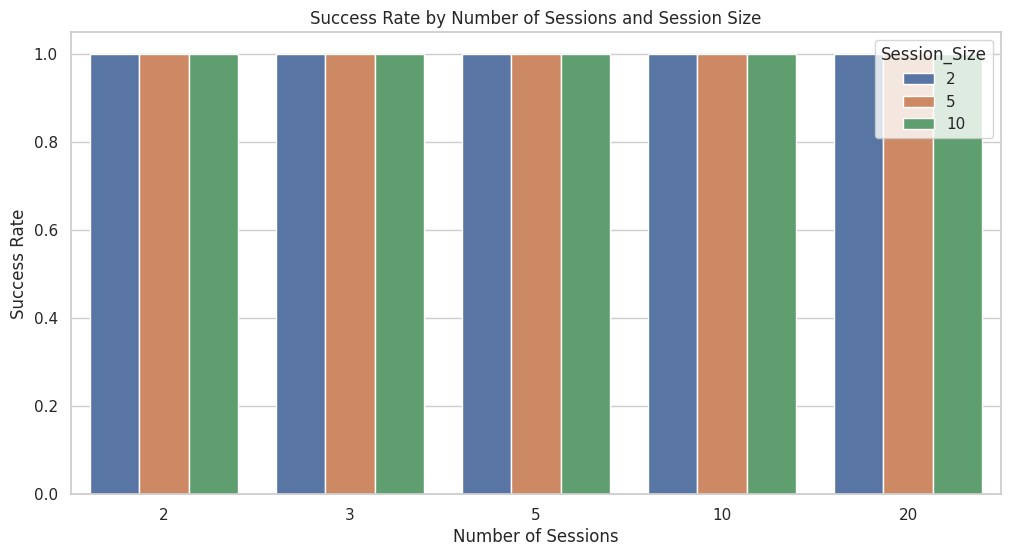

/var/tmp/ipykernel_808463/1561215656.py:54: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num_Sessions', y='Constraint_Num_Papers_Error', hue='Session_Size', data=df, ci=None)


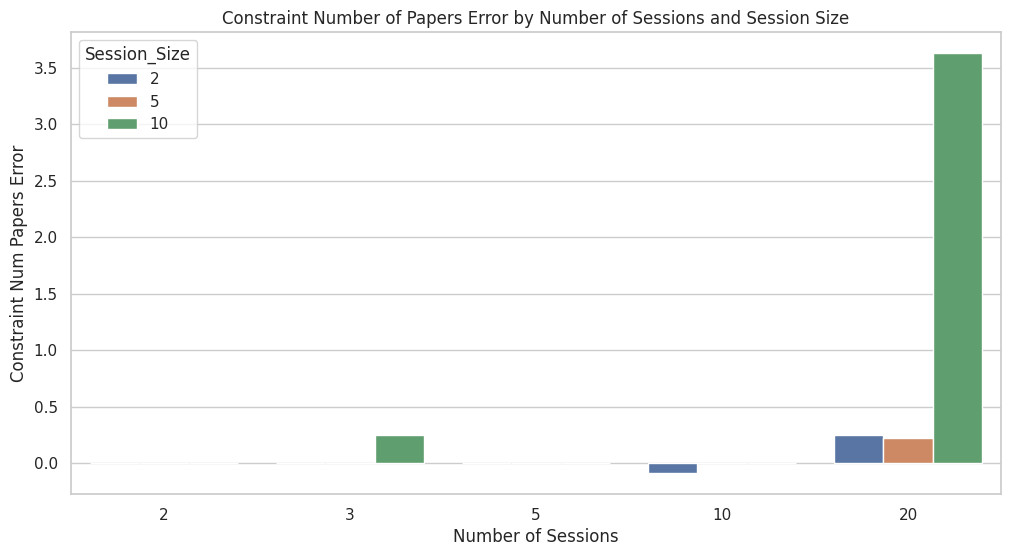

/var/tmp/ipykernel_808463/1561215656.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num_Sessions', y='Constraint_Num_Sessions_Error', hue='Session_Size', data=df, ci=None)


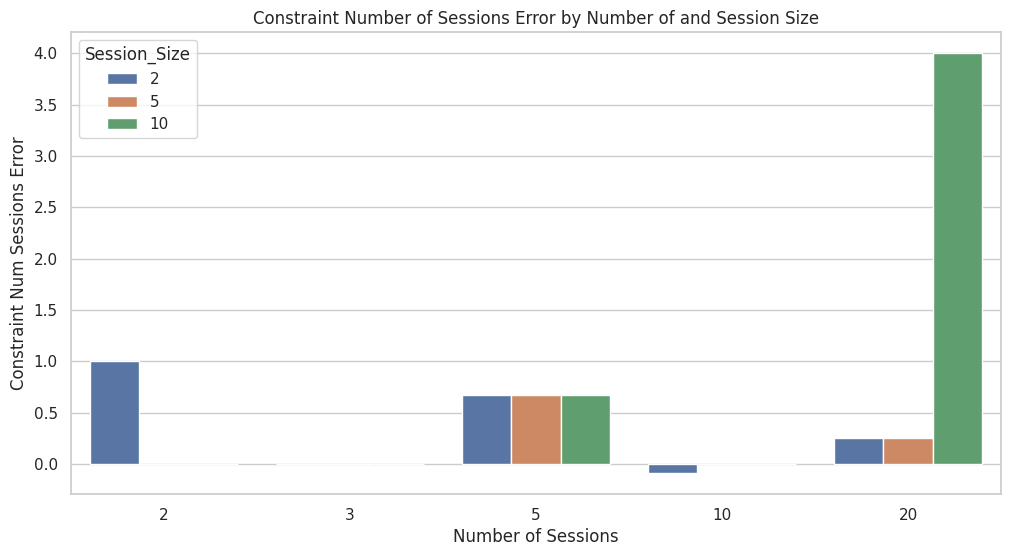

/var/tmp/ipykernel_808463/1561215656.py:69: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Num_Sessions', y='Average_Session_Duration_Error', hue='Session_Size', data=df, ci=None)


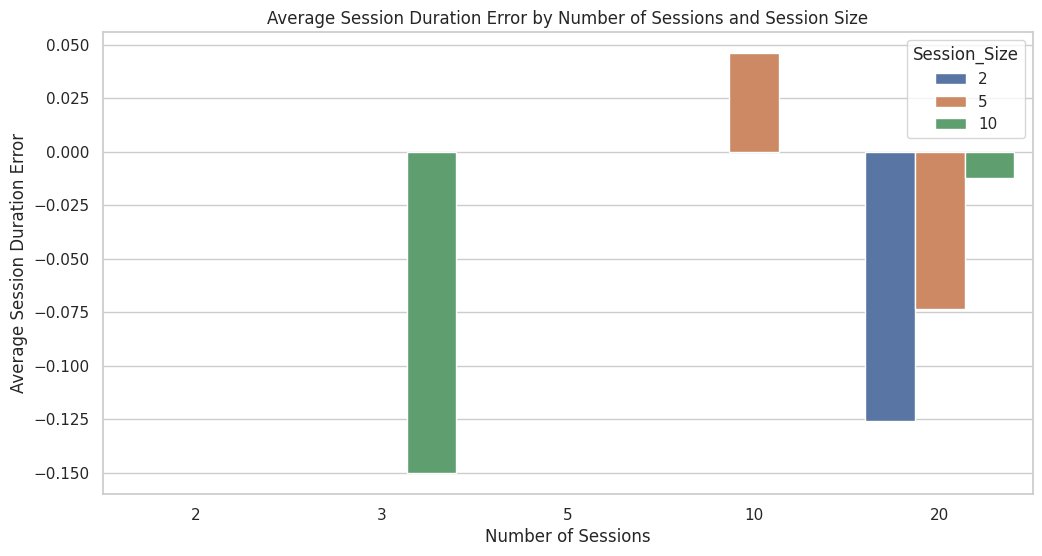

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_eda(all_results):
    # Create a DataFrame to store all relevant metrics for analysis
    data = {
        'Num_Sessions': [],
        'Session_Size': [],
        'Constraint_Num_Papers_Error': [],
        'Constraint_Num_Sessions_Error': [],
        'Average_Session_Duration_Error': [],
        'Success': []
    }

    # Collect data from all_results
    for key, (result, success) in all_results.items():
        num_sessions, session_size = key
        data['Num_Sessions'].append(num_sessions)
        data['Session_Size'].append(session_size)
        data['Success'].append(success)
        
        if success == 1:
            data['Constraint_Num_Papers_Error'].append(result[1]['constraint_num_papers_error'])
            data['Constraint_Num_Sessions_Error'].append(result[1]['constraint_num_sessions_error'])
            
            # Calculate average session duration error
            session_errors = [result[1][k] for k in result[1].keys() if 'constraint_error_session' in k]
            if session_errors:
                avg_error = sum(session_errors) / len(session_errors)
            else:
                avg_error = None
            data['Average_Session_Duration_Error'].append(avg_error)
        else:
            data['Constraint_Num_Papers_Error'].append(None)
            data['Constraint_Num_Sessions_Error'].append(None)
            data['Average_Session_Duration_Error'].append(None)

    df = pd.DataFrame(data)

    # Plotting
    sns.set(style='whitegrid')

    # Success rate per number of sessions and session size
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Num_Sessions', y='Success', hue='Session_Size', data=df, ci=None)
    plt.title('Success Rate by Number of Sessions and Session Size')
    plt.ylabel('Success Rate')
    plt.xlabel('Number of Sessions')
    plt.show()

    # Constraint Errors
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Num_Sessions', y='Constraint_Num_Papers_Error', hue='Session_Size', data=df, ci=None)
    plt.title('Constraint Number of Papers Error by Number of Sessions and Session Size')
    plt.ylabel('Constraint Num Papers Error')
    plt.xlabel('Number of Sessions')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Num_Sessions', y='Constraint_Num_Sessions_Error', hue='Session_Size', data=df, ci=None)
    plt.title('Constraint Number of Sessions Error by Number of and Session Size')
    plt.ylabel('Constraint Num Sessions Error')
    plt.xlabel('Number of Sessions')
    plt.show()

    # Average Session Duration Error
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Num_Sessions', y='Average_Session_Duration_Error', hue='Session_Size', data=df, ci=None)
    plt.title('Average Session Duration Error by Number of Sessions and Session Size')
    plt.ylabel('Average Session Duration Error')
    plt.xlabel('Number of Sessions')
    plt.show()

# Call the function with the all_results dictionary
plot_eda(all_results)